In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler #column standardization
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency
from sklearn import tree
import itertools
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
#===================Loading and understanding the dataset better=============================#
train = pd.read_csv(r'D:\kaggle\input\Train_data.csv')
test = pd.read_csv(r'D:\kaggle\input\Test_data.csv')
#train.info()
#train.head(10)
#train['protocol_type'].value_counts()
#train['flag'].value_counts()
#pd.set_option('display.max_row', None)
#train['service'].value_counts()
pro_flg_serv = train.groupby(['protocol_type','service','class'])['class'].count()
#pro_flg_serv
#train.describe()
# Normalize the data across numeric columns in dataset. Therefore, removing 4 object columns from list
cols_to_norm = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 
                'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
                'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 
                'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 
                'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
                'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
train[cols_to_norm] = StandardScaler().fit_transform(train[cols_to_norm])
test[cols_to_norm] = StandardScaler().fit_transform(test[cols_to_norm])

<AxesSubplot:>

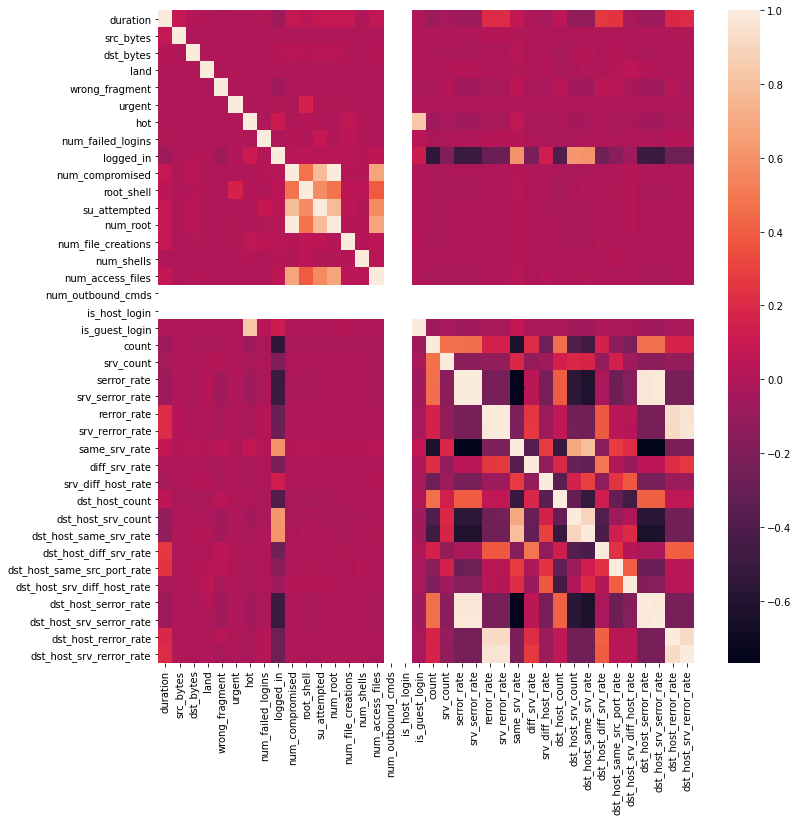

In [3]:
#train.head()

corr_df = train[cols_to_norm].corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(corr_df)

In [4]:
pd.set_option('display.max_column',None)
#corr_df
corr_col_df = pd.DataFrame(columns=["Column1","Column2","Corr_value"])
for i in corr_df.columns:
    for j in corr_df.index:
        if (i != j) and (corr_df[i][j] > 0.7):
            corr_col_df = corr_col_df.append({ "Column1" : i, "Column2" : j, "Corr_value" : corr_df[i][j] }, ignore_index=True)
            #print(i, "\t", j, "\t", corr_df[i][j])
            
corr_col_df

,Column1,Column2,Corr_value
0,hot,is_guest_login,0.833556
1,num_compromised,su_attempted,0.776284
2,num_compromised,num_root,0.998956
3,su_attempted,num_compromised,0.776284
4,su_attempted,num_root,0.774132
5,num_root,num_compromised,0.998956
6,num_root,su_attempted,0.774132
7,is_guest_login,hot,0.833556
8,serror_rate,srv_serror_rate,0.993290
9,serror_rate,dst_host_serror_rate,0.978022


In [6]:
# records are repeating while is creating unnecessary complexity in analysis. Will try to remove duplicate records

ind_list = []
for i in range(len(corr_col_df)):
    for j in range(len(corr_col_df)):
        #print("j", j)
        #print("corr", uni_corr_col_df['Corr_value'][j])
        #print("columns", uni_corr_col_df['Column1'][i], uni_corr_col_df['Column2'][j])
        if ((i!=j) and (corr_col_df['Corr_value'][i] == corr_col_df['Corr_value'][j]) 
            and (corr_col_df['Column1'][i] == corr_col_df['Column2'][j]) 
            and (corr_col_df['Column2'][i] == corr_col_df['Column1'][j])):
            ind_list.append([i,j])

# Unique pair value from list - 
for i in ind_list:
    i.sort()
uni_ind_list = list(set(tuple(i) for i in ind_list)) 


# store unique records into dataframe
uni_corr_col_df = pd.DataFrame(columns=["Column1","Column2","Corr_value"])
for i in uni_ind_list:
    uni_corr_col_df = uni_corr_col_df.append(corr_col_df.iloc[i[0]], ignore_index=True)
    
uni_corr_col_df

,Column1,Column2,Corr_value
0,srv_serror_rate,dst_host_srv_serror_rate,0.984621
1,rerror_rate,dst_host_srv_rerror_rate,0.964886
2,su_attempted,num_root,0.774132
3,dst_host_srv_count,dst_host_same_srv_rate,0.895512
4,dst_host_rerror_rate,dst_host_srv_rerror_rate,0.925390
5,num_compromised,num_root,0.998956
6,num_compromised,su_attempted,0.776284
7,serror_rate,dst_host_serror_rate,0.978022
8,srv_rerror_rate,dst_host_srv_rerror_rate,0.969841
9,rerror_rate,dst_host_rerror_rate,0.928992


In [7]:
# identifying columns to delete from dataframe
col_corr = set() # Set of all the names of deleted columns
for i in range(len(uni_corr_col_df)):
    if (uni_corr_col_df['Column1'][i] not in col_corr):
        colname = uni_corr_col_df['Column2'][i] # getting the name of column
        col_corr.add(colname)

col_corr = list(col_corr)
print(col_corr)

# dropping identified columns from train and test dataset
train.drop(col_corr, axis=1, inplace=True)
test.drop(col_corr, axis=1, inplace=True)

['dst_host_serror_rate', 'is_guest_login', 'num_root', 'su_attempted', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'srv_serror_rate', 'dst_host_srv_count']


In [8]:
#print(train.shape)
#test.shape

col_corr = set() # Set of all the names of deleted columns
for i in range(len(corr_df.columns)):
    for j in range(i):
        if (corr_df.iloc[i, j] >= 0.7) and (corr_df.columns[j] not in col_corr):
            colname = corr_df.columns[i] # getting the name of column
            col_corr.add(colname)
col_corr = list(col_corr)
print(col_corr)

# dropping identified columns from train and test dataset

['dst_host_serror_rate', 'is_guest_login', 'num_root', 'su_attempted', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'srv_serror_rate', 'dst_host_srv_count']


In [9]:
#print(train.shape)
#test.shape

# we need to pass data in cross tabular format to chi2_contingency. Therefore, using pd.crosstab
# we are assuming that significant value is 0.05
alpha = 0.05
stat, p, dof, expected = chi2_contingency(pd.crosstab(train['protocol_type'], train['class']))
print("p", p)

if p<=alpha:
    print("\nprotocol_type and class columns are dependent")
else:
    print("\nprotocol_type and class columns are independent")

p 0.0

protocol_type and class columns are dependent


In [10]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train['service'], train['class']))
print("p", p)

if p<=alpha:
    print("\nservice and class columns are dependent")
else:
    print("\nservice and class columns are independent")

p 0.0

service and class columns are dependent


In [11]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train['flag'], train['class']))
print("p", p)

if p<=alpha:
    print("\nflag and class columns are dependent")
else:
    print("\nflag and class columns are independent")

p 0.0

flag and class columns are dependent


In [12]:
# convert dependent variable to number.
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

y = train['class']
#y.shape

X = train.drop('class', axis=1)
X.shape

(25192, 30)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



0.9965599364911352

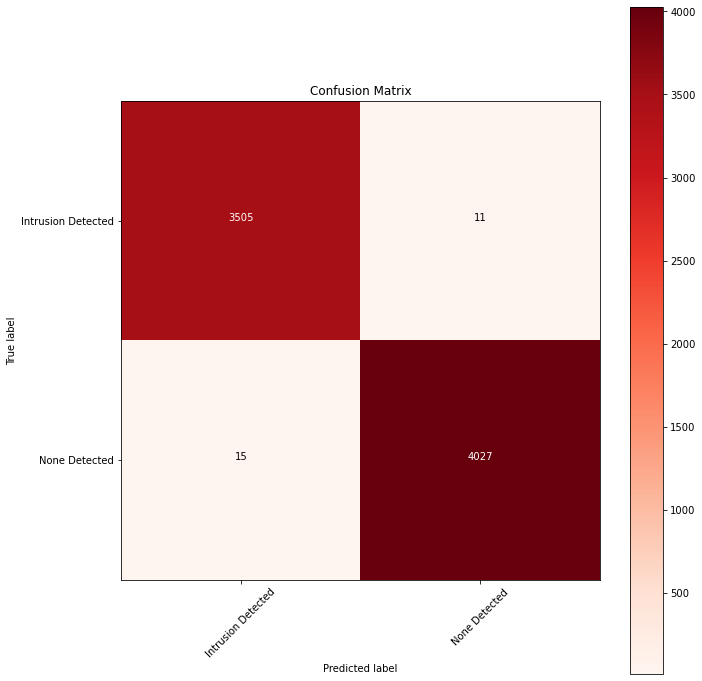

In [13]:
X = pd.get_dummies(X)
#X.head()
#X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, y_train)
y_pred1 = DTC_Classifier.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred1)
print(classification_report(y_test, y_pred1))

# Now i want to evaluate the model with popular performance metrics
def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Intrusion Detected", "None Detected"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_test, y_pred1)


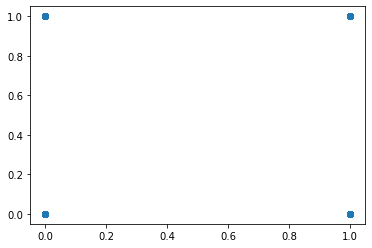

In [14]:
plt.scatter(y_test, y_pred1)
plt.show()

roc_auc_score for Decision tree:  0.9965802053410746


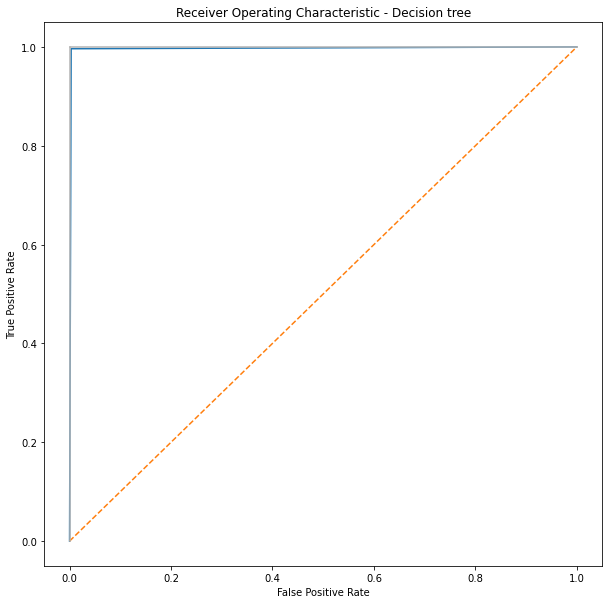

In [15]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred1)
print('roc_auc_score for Decision tree: ', roc_auc_score(y_test, y_pred1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3516
           1       0.99      0.99      0.99      4042

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558



0.9895474993384493

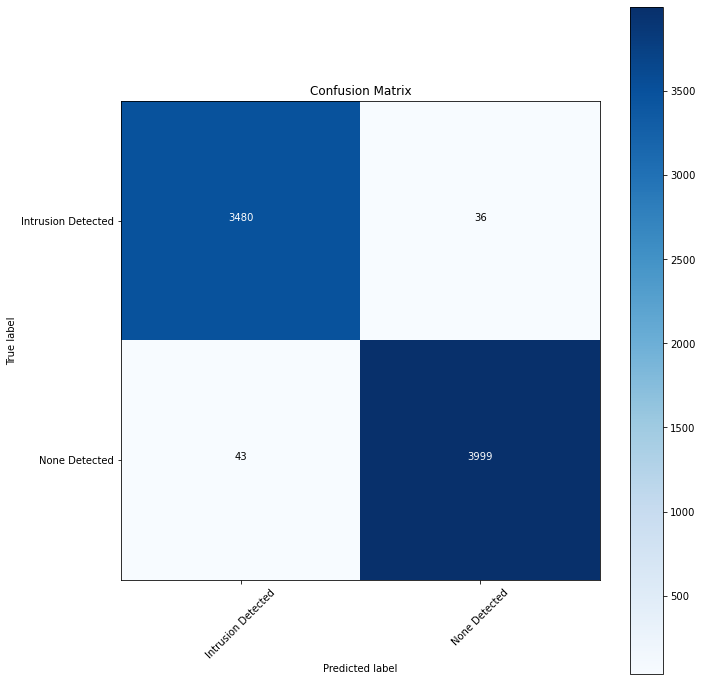

In [16]:
#Train SVM model
SVM_Classifier = SVC(random_state=0)
SVM_Classifier.fit(X_train, y_train)
y_pred2 = SVM_Classifier.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
print(classification_report(y_test, y_pred2))

def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Intrusion Detected", "None Detected"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_test, y_pred2)


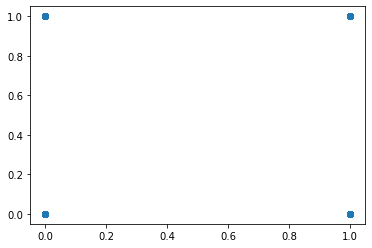

In [17]:
plt.scatter(y_test, y_pred2)
plt.show()

roc_auc_score for SVM:  0.9895613971389151


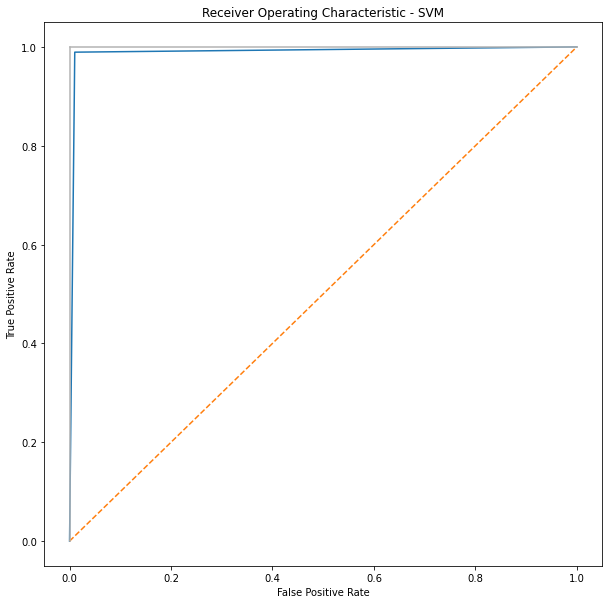

In [18]:
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred2)
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_pred2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3516
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



0.9977507277057422

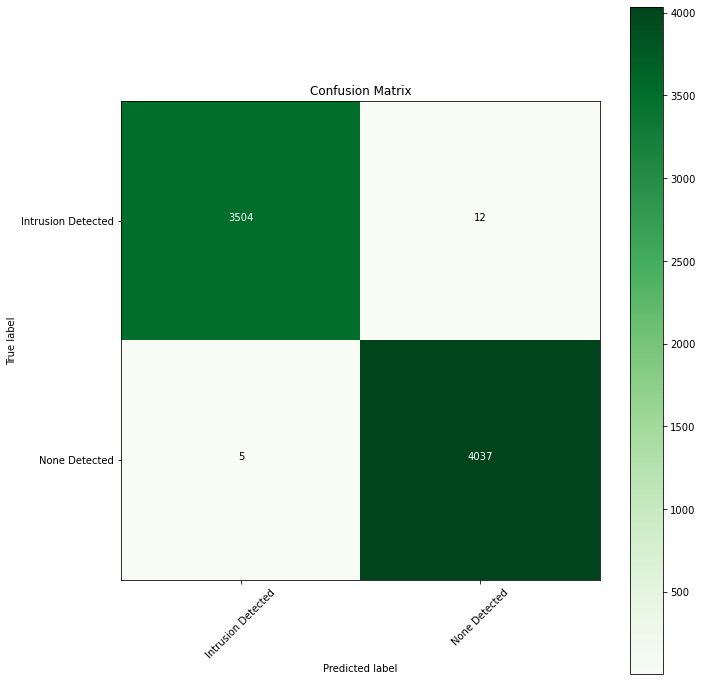

In [19]:
rfc = RandomForestClassifier(random_state=1)
rfc.fit(X_train, y_train)
y_pred3 = rfc.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3))

def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Intrusion Detected", "None Detected"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_test, y_pred3)

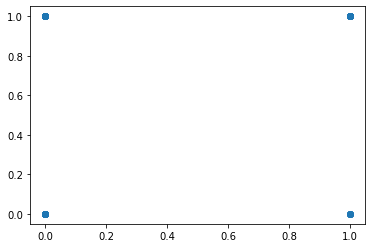

In [20]:
plt.scatter(y_test, y_pred3)
plt.show()

roc_auc_score for Random Forest:  0.9976750096681094


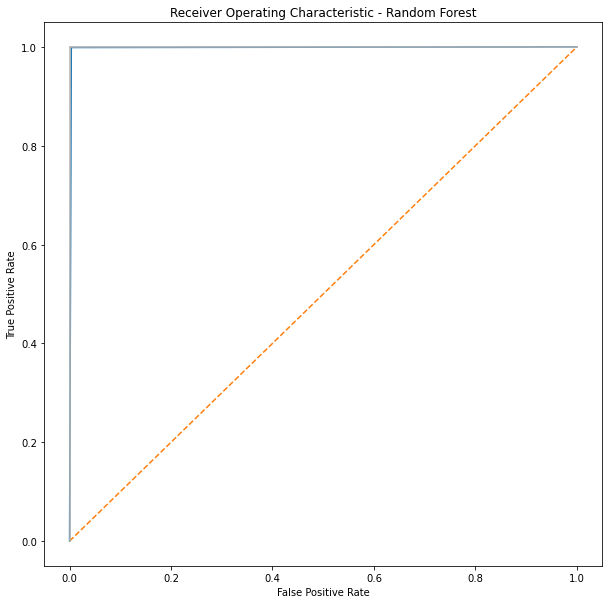

In [21]:
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_pred3)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_pred3))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()